In [1]:
import itertools as it
import more_itertools as mit
import networkx as nx
from collections import Counter
import copy
import matplotlib.pyplot as plt
import random
from fractions import Fraction
import math
import numpy as np
from functools import reduce
from operator import mul
import json
import re

def collapse(fraction):
    if fraction < 1:
        while fraction < 1:
            fraction *= Fraction(2, 1)
    elif fraction >= 2:
        while fraction >= 2:
            fraction *= Fraction(1, 2)
    return fraction

def collapse_point(point):
    return tuple([p for p in point if abs(p) != 2])

def hs_point_to_fr(point):
    if point is None:
        return None
    else:
        fraction = Fraction(1, 1)
        for dim in point:
            if dim > 0:
                fraction = fraction * dim
            else:
                fraction = fraction * 1/abs(dim)
        return fraction
    
def pitches(iterable, r):
    for base in it.combinations_with_replacement(iterable, r):
        split = tuple(list(g) for k, g in it.groupby(tuple(b for b in base if b != 1)))
        mults = list(it.product([-1, 1], repeat = len(split)))
        for mult in mults:
            yield tuple(it.chain(*[[val * mult[idx] for val in g] for idx, g in enumerate(split)]))

def expand_pitch(pitch):
    num = 1;
    den = 1;
    expanded_pitch = list(pitch)
    for dim in pitch:
        if dim > 0:
            num *= dim
        else:
            den *= abs(dim)
    fraction = num/den
    if fraction < 1:
        while fraction < 1:
            fraction *= 2
            expanded_pitch = [2] + expanded_pitch
    elif fraction >= 2:
        while fraction >= 2:
            fraction *= 1/2
            expanded_pitch = [-2] + expanded_pitch
    return tuple(expanded_pitch)

def expand_chord(chord):
    return tuple([expand_pitch(p) for p in chord])

def transpose_pitch(pitch, trans):
    if pitch is None:
        return None
    else:
        transposed_pitch = list(pitch)
        for t in trans:
            if (t * -1) in transposed_pitch:
                transposed_pitch.remove(t * -1)
            else:
                transposed_pitch.append(t)
        transposed_pitch.sort(key=lambda val: abs(val))
        return tuple(transposed_pitch)
    
def transpose_chord(chord, trans):
    transposed_chord = list(chord)
    for pdx, pitch in enumerate(chord):
        transposed_pitch = transpose_pitch(pitch, trans)
        transposed_chord[pdx] = tuple(transposed_pitch)
    return tuple(transposed_chord)
    
def chords(pitches, min_chord_size, max_chord_size):
    def is_connected(iterable):
        points = comparitors = list(iterable)
        connected_points = []
        base = points[0]
        bidx = 0
        while True:
            for comp in comparitors:
                comps = sorted([base, comp], key=len, reverse=True)
                if ((Counter(comps[0]) - Counter(comps[1])).total() == 1) and (len(comps[0]) - len(comps[1]) == 1):
                    comparitors = connected_points = connected_points + comps
                    points.remove(base)
                    if comp in points:
                        points.remove(comp)
                    if(len(points) == 0):
                        return True
                    else:
                        base = points[0]
                        bidx = 0
                        break
            else:
                if bidx < (len(points) - 1):
                    bidx += 1
                    base = points[bidx]
                else:
                    return False
    def is_centered(iterable):
        return len(list(iterable)[0]) == 0
    #return filter(is_connected, it.takewhile(is_centered, it.combinations(pitches, r)))
    #return {c for c in it.takewhile(is_centered, it.combinations(pitches, min_chord_size)) if is_connected(c)}
    chords = []
    pitches = list(pitches)
    for chord_size in range(min_chord_size, max_chord_size + 1):
        chords = chords + list({c for c in it.takewhile(is_centered, it.combinations(pitches, chord_size)) if is_connected(c)})
    return chords

def pitch_difference(frs):
    if None in frs:
        return None
    else:
        cents1 = (1200 * math.log(hs_point_to_fr(frs[0]), 2))
        cents2 = (1200 * math.log(hs_point_to_fr(frs[1]), 2))
        return cents2 - cents1

def difference(p1, p2):
    return transpose_pitch(p1, [p * -1 for p in p2])

def edges(chords, min_symdiff, max_symdiff, max_chord_size):    
    def reverse_dict(dict):
        rev_dict = copy.deepcopy(dict)
        rev_trans = tuple(t * -1 for t in rev_dict['transposition'])
        rev_dict['transposition'] = rev_trans
        #rev_dict['movements'] = {transpose_pitch(value['destination'], rev_trans):{'destination':transpose_pitch(key, rev_trans), 'pitch_difference':value['pitch_difference']} for key, value in rev_dict['movements'].items()}
        rev_dict['movements'] = {value['destination']:{'destination':key, 'pitch_difference':value['pitch_difference']} for key, value in rev_dict['movements'].items()}
        return rev_dict

    def is_directly_tunable(intersection, diff):
        return max([len(collapse_point(difference(d, set(list(intersection)[0])))) for d in diff]) == 1
        
    def edge_data(iterable):
        [base, comp] = list(iterable)
        expanded_base = expand_chord(base)
        expanded_comp = expand_chord(comp)
        edges = []
        transpositions = set([tuple(difference(pair[0], pair[1])) for pair in set(it.product(expanded_base, expanded_comp))])
        for trans in transpositions:
            rev_trans = tuple(t * -1 for t in trans)
            expanded_compTransposed = transpose_chord(expanded_comp, trans)
            intersection = set(expanded_base) & set(expanded_compTransposed)
            diff1 = list(set(expanded_base) - intersection)
            diff2 = list(set(expanded_compTransposed) - intersection)
            base_map = {val: {'destination':transpose_pitch(val, rev_trans), 'pitch_difference': 0} for val in intersection}
            symdiff_len = (len(diff1) + len(diff2))
            if (min_symdiff <= (len(diff1) + len(diff2)) <= max_symdiff):
                edge_dict = {}
                edge_dict['transposition'] = trans
                edge_dict['symmetric_difference'] = symdiff_len
                edge_dict['is_directly_tunable'] = is_directly_tunable(intersection, diff2)
                maps = []
                diff1 += [None] * (max_chord_size - len(diff1) - len(intersection))
                #diff2 += [None] * (max_chord_size - len(diff2) - len(intersection))
                #this could be faster
                perms = set(it.permutations(diff2))
                perms = [list(perm) + [None] * (max_chord_size - len(perm) - len(intersection)) for perm in perms]
                for p in perms:
                    appended_map = {diff1[index]: {'destination':transpose_pitch(val, rev_trans), 'pitch_difference': pitch_difference([diff1[index], val])} for index, val in enumerate(p)}
                    edge_dict['movements'] = base_map | appended_map
                    edges.append((expanded_base, expanded_comp, edge_dict))
                    edges.append((expanded_comp, expanded_base, reverse_dict(edge_dict)))
        if edges != []:
            return edges
        else:
            return None
    return list(it.chain(*[e for c in it.combinations(chords, 2) if (e := edge_data(c)) is not None]))

def graph_from_edges(edges):
    G = nx.MultiDiGraph()
    G.add_edges_from(edges)
    return G

def hamiltonian(G):
    F = [(G,[list(G.nodes())[0]])]
    n = G.number_of_nodes()
    while F:
        graph,path = F.pop()
        confs = []
        neighbors = (node for node in graph.neighbors(path[-1]) 
                     if node != path[-1]) #exclude self loops
        for neighbor in neighbors:
            conf_p = path[:]
            conf_p.append(neighbor)
            conf_g = nx.Graph(graph)
            conf_g.remove_node(path[-1])
            confs.append((conf_g,conf_p))
        for g,p in confs:
            if len(p)==n:
                return p
            else:
                F.append((g,p))
    return None

def generate_graph(primes, min_chord_size, max_chord_size, min_symdiff, max_symdiff):
    pitch_set = pitches(primes, max_chord_size)
    #print(len(list(pitch_set)))
    chord_set = chords(pitch_set, min_chord_size, max_chord_size)
    #print(chord_set)
    edge_set = edges(chord_set, min_symdiff, max_symdiff, max_chord_size)
    #for e in edge_set:
    #    print(e)
    res_graph = graph_from_edges(edge_set)
    return res_graph

def display_graph(graph):
    show_graph = nx.Graph(graph)
    pos = nx.draw_spring(show_graph, node_size=5, width=0.1)
    
    # larger figure size
    plt.figure(1, figsize=(12,12)) 
    nx.draw(show_graph, pos, node_size=5, width=0.1)
    #plt.show()
    plt.savefig('compact_sets.png', dpi=150)

def reconcile_path(path):
    reconciled_path = [[(), sorted([p for p in list(path[0][2]['movements'].keys())])]]    
    #print(reconciled_path)
    for cdx in range(len(path)-1):
        movements = path[cdx][2]['movements']
        next_chord = [movements[p]['destination'] for p in reconciled_path[-1][1]]
        trans = path[cdx][2]['transposition']
        reconciled_path.append([trans, next_chord])
    return reconciled_path

def reconcile_path_alt(path):
    def build_dict_entry(cur_root, transposed_chord, transposed_frs, trans, untransposed_chord, untransposed_frs):
        dict_entry = {
            'current_root': cur_root, 
            'hs_array_transposed': transposed_chord, 
            'frequency_ratios_transposed': transposed_frs, 
            'transposition': trans, 
            'hs_array_untransposed': untransposed_chord,
            'frequency_ratios_untransposed': untransposed_frs
        }
        return dict_entry
        
    current_root = []
    init_chord =  sorted([p for p in list(path[0][2]['movements'].keys())])
    init_frs = [float(hs_point_to_fr(p)) for p in init_chord]
    reconciled_path = [build_dict_entry(current_root, init_chord, init_frs, current_root, init_chord, init_frs)]
    #print(reconciled_path)
    for cdx in range(len(path)-1):
        movements = path[cdx][2]['movements']
        next_chord_untransposed = [movements[p]['destination'] for p in reconciled_path[-1]['hs_array_untransposed']]
        trans = path[cdx][2]['transposition']
        current_root = transpose_pitch(current_root, trans)
        next_chord_transposed = [transpose_pitch(p, current_root) for p in next_chord_untransposed]
        frs = [hs_point_to_fr(p) for p in next_chord_transposed]
        reconciled_path.append(build_dict_entry(current_root, next_chord_transposed, init_frs, trans, next_chord_untransposed, init_frs))
    return reconciled_path

def path_to_chords(path):
    current_root = Fraction(1, 1)
    chords = []
    for trans, points in path:
        current_root = current_root * hs_point_to_fr(trans)
        chord = [float(current_root * hs_point_to_fr(p)) if p is not None else None for p in points]
        chords.append(chord)
    return chords

def gen_chord_sequence(graph, path_func):
    ipath = path_func(graph)
    print(ipath[0])
    ipath = [list(e) for e in ipath]
    #print(ipath)
    reconciled_path_alt = reconcile_path_alt(ipath)
    reconciled_path = reconcile_path(ipath)
    print(reconciled_path[0:5])
    print(reconciled_path_alt[0:5])
    res_path = path_to_chords(reconciled_path)
    #return res_path
    return reconciled_path_alt

def write_chord_sequence(path):
    # Opening a file in write mode{
    file = open("seq.txt", "w+")
    
    # Converting the array to a string and writing to the file
    #content = str(path).replace("None", "[\"Rest\"]")
    content = json.dumps(path)
    content = content.replace(", \"", ",\n\t\"")
    file.write(content)
    
    # Closing the file
    file.close()

In [32]:
graph = generate_graph([1, 3, 5, 7, 11], 3, 3, 4, 4)

In [33]:
def stochastic_hamiltonian(graph):
        
    def movement_size_weights(edges):
        
        def max_pitch_diff(edge):
            res = max([abs(v) for val in edge[2]['movements'].values() if (v:=val['pitch_difference']) is not None])
            return res
            
        def min_pitch_diff(edge):
            res = [abs(v) for val in edge[2]['movements'].values() if (v:=val['pitch_difference']) is not None]
            res.remove(0)
            return min(res)
            
        return [(1000 if ((max_pitch_diff(e) < 200) and (min_pitch_diff(e)) > 50) else 1) for e in edges]

    
    def hamiltonian_weights(edges):
        return [(10 if e[1] not in [path_edge[0] for path_edge in path] else 1) for e in edges] 

    
    def contrary_motion_weights(edges):

        def is_contrary(edge):
            pitch_diffs = [v for val in edge[2]['movements'].values() if (v:=val['pitch_difference']) is not None]
            pitch_diffs.sort()
            return (pitch_diffs[0] < 0) and (pitch_diffs[1] == 0) and (pitch_diffs[2] > 0)
            
        return [(2 if is_contrary(e) else 1) for e in edges]

    
    def is_directly_tunable_weights(edges):
        return [(10 if e[2]['is_directly_tunable'] else 1) for e in edges]

    
    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_point_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_point_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            #print(source_order != destination_order)
            return source_order != destination_order
            
        return [(10 if not has_voice_crossing(e) else 0) for e in edges]
        
    
    check_graph = graph.copy()
    next_node = random.choice(list(graph.nodes()))
    check_graph.remove_node(next_node)
    path = []
    while (nx.number_of_nodes(check_graph) > 0) and (len(path) < 5000):
        out_edges = list(graph.out_edges(next_node, data=True))
        #print([l for l in zip(movement_size_weights(out_edges), hamiltonian_weights(out_edges))])
        factors = [
            movement_size_weights(out_edges), 
            hamiltonian_weights(out_edges), 
            contrary_motion_weights(out_edges), 
            is_directly_tunable_weights(out_edges),
            voice_crossing_weights(out_edges)
        ]
        weights = [math.prod(a) for a in zip(*factors)]
        #weights = [reduce(mul, x) for x in [movement_size_weights(out_edges), hamiltonian_weights(out_edges)]]
        #print(weights)
        edge = random.choices(out_edges, weights=weights)[0]
        #edge = random.choice(out_edges)
        next_node = edge[1]
        path.append(edge)
        if next_node in check_graph.nodes:
            check_graph.remove_node(next_node)
    return path
    
seq = gen_chord_sequence(graph, stochastic_hamiltonian)
write_chord_sequence(seq)
len(seq)

(((), (-2, 3), (-2, -2, 5)), ((), (2, 2, -3), (2, 2, 2, -5)), {'transposition': (), 'symmetric_difference': 4, 'is_directly_tunable': True, 'movements': {(): {'destination': (), 'pitch_difference': 0}, (-2, -2, 5): {'destination': (2, 2, -3), 'pitch_difference': -111.73128526977763}, (-2, 3): {'destination': (2, 2, 2, -5), 'pitch_difference': -111.73128526977791}}})
[[(), [(), (-2, -2, 5), (-2, 3)]], [(), [(), (2, 2, -3), (2, 2, 2, -5)]], [(), [(), (-2, -2, -2, -2, -2, -2, 7, 11), (-2, -2, 7)]], [(-2, -2, -2, -2, -2, 5, 7), [(), (2, 2, 2, 2, -3, -5), (2, 2, 2, -5)]], [(2, 2, 2, 2, 2, 2, 2, 2, -5, -5, -11), [(), (-2, -2, 5), (-2, -2, -2, -2, -2, 5, 11)]]]
[{'current_root': [], 'hs_array_transposed': [(), (-2, -2, 5), (-2, 3)], 'frequency_ratios_transposed': [1.0, 1.25, 1.5], 'transposition': [], 'hs_array_untransposed': [(), (-2, -2, 5), (-2, 3)], 'frequency_ratios_untransposed': [1.0, 1.25, 1.5]}, {'current_root': (), 'hs_array_transposed': [(), (2, 2, -3), (2, 2, 2, -5)], 'frequency_r

255

In [91]:
sorted(((), (-2, 3), (-2, -2, -2, 3, 3)))

[(), (-2, -2, -2, 3, 3), (-2, 3)]

In [2]:
pitch_set = pitches([1, 3, 5, 7, 11], 3)
#print(list(pitch_set))
chord_set = chords(pitch_set, 3, 3)
#test = list(chord_set)
#print(len(test))
#print(test)
#edge_set = edges(chord_set, 4, 4, 3)
#for e in edge_set:
#    print(e)
#testGraph = graph_from_edges(edge_set)
#edge_set

In [5]:
test = edges(chord_set, 4, 4, 3)

In [6]:
len(test)

110712

In [24]:
len(testGraph.edges)

302730

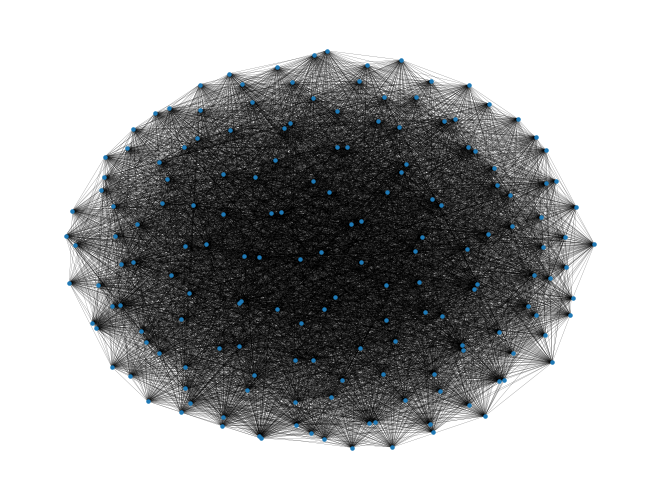

In [5]:
show_graph = nx.Graph(testGraph)
pos = nx.draw_spring(show_graph, node_size=5, width=0.1)

# larger figure size
plt.figure(1, figsize=(12,12)) 
nx.draw(show_graph, pos, node_size=5, width=0.1)
#plt.show()
plt.savefig('compact_sets.png', dpi=150)

In [25]:
def reconcile_path(ham, max_chord_size):
    reconciled_path = [[(), [p for p in list(ham[0][2]['movements'].keys())]]]
    print(reconciled_path)
    for cdx in range(len(ham)-1):
        movements = ham[cdx][2]['movements']
        next_chord = [movements[p]['destination'] for p in reconciled_path[-1][1]]
        trans = ham[cdx][2]['transposition']
        reconciled_path.append([trans, next_chord])
    return reconciled_path

ham = stochastic_hamiltonian(testGraph)
ham = [list(e) for e in ham]
#print(len(ham))
#for e in ham:
#    print(e[0])
#    print(e[1])
#    print('transposition:')
#    print(e[2]['transposition'])
#    print('movements:')
#    for movement in e[2]['movements']:
#        print(movement)
#    print("---------")
reconciled_path = reconcile_path(ham, 4)
reconciled_path

[[(), [(2, 2, 2, -7), (), (-2, -2, 5)]]]


[[(), [(2, 2, 2, -7), (), (-2, -2, 5)]],
 [(2, 2, -7, -7, 13), [(2, 7, -13), (), (2, 2, 2, 2, -13)]],
 [(2, 2, 2, 2, 2, 2, 2, -11, -13), [(-2, -2, 5), (), (-2, -2, -2, 11)]],
 [(-2, 3, 5, -7), [(-2, -3, 7), (), (2, 2, -3)]],
 [(2, 2, 2, 2, 2, -3, -11),
  [(-2, -2, -2, -2, -2, -2, 7, 11), (), (-2, -2, -2, 11)]],
 [(-2, -2, -2, -2, -5, 7, 11), [(2, 2, 2, -7), (), (2, 5, -7)]],
 [(-2, -2, 5, 5, -7), [(2, 3, -5), (), (2, 2, 2, -5)]],
 [(3, -5, -7, 11), [(2, 7, -11), (), (-2, -2, 7)]],
 [(), [(-2, -2, -2, 11), (), (-2, -2, -2, -2, -2, 5, 11)]],
 [(), [(2, 2, 2, 2, -11), (), (-2, -2, -2, 13)]],
 [(), [(2, 2, -3), (), (-2, -2, -2, 13)]],
 [(), [(2, 2, 2, 2, -13), (), (2, 2, 2, 2, 2, 2, 2, 2, -11, -13)]],
 [(), [(-2, -2, 5), (), (-2, -2, -2, -2, -2, 5, 11)]],
 [(), [(2, 2, 2, -7), (), (2, 2, 3, -7)]],
 [(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, -7, -11, -13),
  [(-2, -2, -2, -2, -2, -2, -2, 11, 13), (), (-2, -2, -2, 13)]],
 [(), [(2, 2, 2, -7), (), (2, 2, 2, 2, -11)]],
 [(2, 2, 2, 2, 2, 3, -7, -13), [(-2

In [27]:
def path_to_chords(path):
    current_root = Fraction(1, 1)
    chords = []
    for trans, points in path:
        current_root = current_root * hs_point_to_fr(trans)
        chord = [float(current_root * hs_point_to_fr(p)) if p is not None else None for p in points]
        chords.append(chord)
    return chords

fPath = path_to_chords(reconciled_path)
len(set([tuple(p) for p in fPath]))
fPath

[[1.1428571428571428, 1.0, 1.25],
 [1.1428571428571428, 1.0612244897959184, 1.3061224489795917],
 [1.1873840445269017, 0.9499072356215214, 1.3061224489795917],
 [1.1873840445269017, 1.01775775245163, 1.3570103366021733],
 [1.1873840445269017, 0.9869166084379443, 1.3570103366021733],
 [1.0856082692817386, 0.9499072356215214, 1.3570103366021733],
 [1.01775775245163, 0.8481314603763583, 1.3570103366021733],
 [1.01775775245163, 0.7996668054977093, 1.3994169096209912],
 [1.0995418575593503, 0.7996668054977093, 1.3744273219491878],
 [1.1631517170875771, 0.7996668054977093, 1.2994585589337775],
 [1.066222407330279, 0.7996668054977093, 1.2994585589337775],
 [0.9842052990741037, 0.7996668054977093, 1.4315713441077873],
 [0.9995835068721366, 0.7996668054977093, 1.3744273219491878],
 [0.9139049205688106, 0.7996668054977093, 1.3708573808532158],
 [0.9139049205688106, 0.8180407680615928, 1.3293162481000882],
 [0.9349037349275345, 0.8180407680615928, 1.1898774808168622],
 [0.9349037349275345, 0.8629

In [21]:
# Opening a file in write mode{
file = open("seq.txt", "w+")

# Converting the array to a string and writing to the file
content = str(fPath).replace("None", "[\"Rest\"]")
file.write(content)

# Closing the file
file.close()

In [279]:
for edge in list(testGraph.edges(data=True))[:1000]:
    print(edge)

(((), (2, 2, 2, -7), (2, 2, 2, 2, 2, 2, -5, -7), (2, 2, 2, 2, 3, -5, -7)), ((), (2, 2, 2, 2, -13), (2, 2, 2, 2, 2, 2, 2, -5, -13), (2, 2, 2, 2, 2, 3, -5, -13)), {'melodic_movement': 128.2982446998143, 'transposition': (-2, -7, 13)})
(((), (2, 2, 2, -7), (2, 2, 2, 2, 2, 2, -5, -7), (2, 2, 2, 2, 3, -5, -7)), ((), (2, 2, 2, -5), (2, 3, -5), (3, 3, -5)), {'melodic_movement': 1248.7703813968149, 'transposition': (2, 2, 2, -7)})
(((), (2, 2, 2, -7), (2, 2, 2, 2, 2, 2, -5, -7), (2, 2, 2, 2, 3, -5, -7)), ((), (2, 2, 2, -5), (2, 3, -5), (-2, -5, 11)), {'melodic_movement': 396.17832203079695, 'transposition': (2, 2, 2, -7)})
(((), (2, 2, 2, -7), (2, 2, 2, 2, 2, 2, -5, -7), (2, 2, 2, 2, 3, -5, -7)), ((), (2, 2, 2, -5), (-2, -2, 7), (2, 3, -5)), {'melodic_movement': 1200.0, 'transposition': (2, 2, 2, -7)})
(((), (2, 2, 2, -7), (2, 2, 2, 2, 2, 2, -5, -7), (2, 2, 2, 2, 3, -5, -7)), ((), (2, 2, 2, -5), (-2, -2, -2, 13), (2, 3, -5)), {'melodic_movement': 1071.7017553001858, 'transposition': (2, 2, 2, 

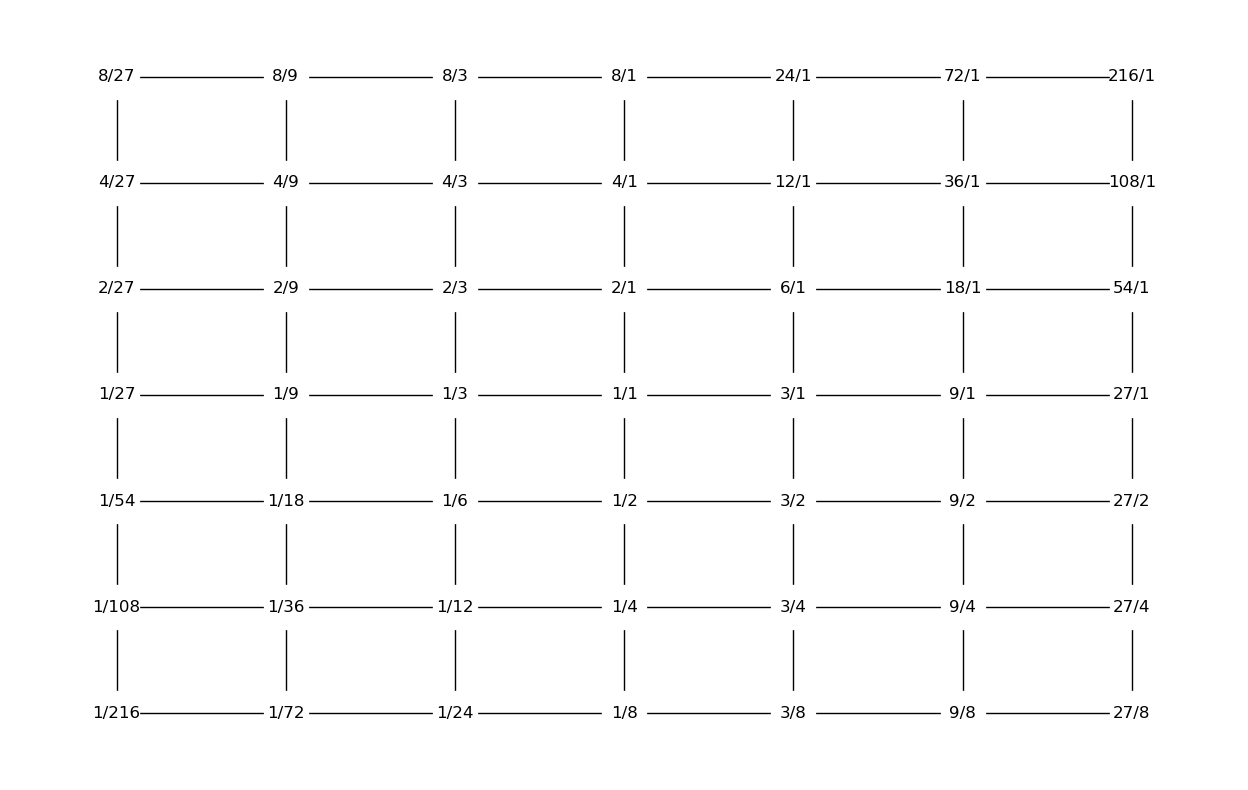

In [161]:
import networkx as nx
from matplotlib import pyplot as plt
import math

G = nx.grid_graph(dim=(range(-3, 4), range(-3, 4)))

def getLabel(x, y):
    num = 1
    den = 1
    if x >= 0:
        num *= math.pow(3, x)
    else:
        den *= math.pow(3, abs(x))
    if y >= 0:
        num *= math.pow(2, y)
    else:
        den *= math.pow(2, abs(y))
    return str(int(num)) + "/" + str(int(den))
    
        

plt.figure(figsize=(10 * math.log2(3), 10 * math.log2(2)))
#plt.figure(figsize=(10, 10))
pos = {(x, y):(x * math.log2(3), y * math.log2(2)) for x,y in G.nodes()}
labels = {(x, y):getLabel(x, y) for x,y in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels)
nx.draw(G, pos=pos, 
        node_color='white', 
        with_labels=False,
        node_size=1000)

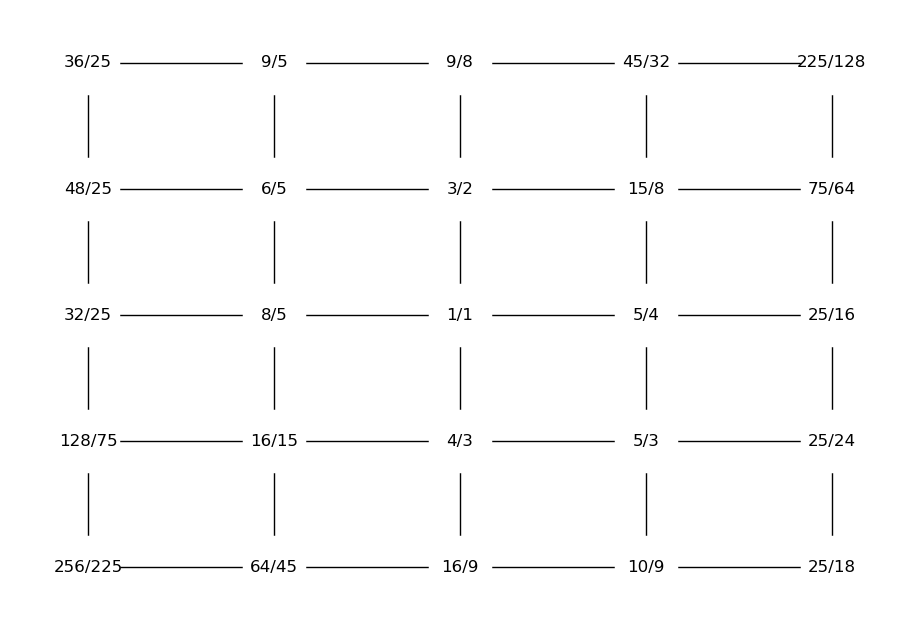

In [160]:
import networkx as nx
from matplotlib import pyplot as plt
import math

G = nx.grid_graph(dim=(range(-2, 3), range(-2, 3)))

def collapseLabel(fraction):
    if fraction < 1:
        while fraction < 1:
            fraction *= Fraction(2, 1)
    elif fraction >= 2:
        while fraction >= 2:
            fraction *= Fraction(1, 2)
    return fraction
    
def getLabel(x, y):
    num = 1
    den = 1
    if x >= 0:
        num *= math.pow(5, x)
    else:
        den *= math.pow(5, abs(x))
    if y >= 0:
        num *= math.pow(3, y)
    else:
        den *= math.pow(3, abs(y))
    fraction = collapse(Fraction(int(num), int(den)))
    num = fraction.numerator
    den = fraction.denominator
    return str(int(num)) + "/" + str(int(den))

plt.figure(figsize=(5 * math.log2(5), 5 * math.log2(3)))
#plt.figure(figsize=(10, 10))
pos = {(x, y):(x, y) for x,y in G.nodes()}
labels = {(x, y):getLabel(x, y) for x,y in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels)
nx.draw(G, pos=pos, 
        node_color='white', 
        with_labels=False,
        node_size=2000)

In [44]:
for node in list(testGraph.nodes)[2:3]:
    edges = list(testGraph.out_edges(node, data=True))
    for edge in edges:
        if list(edge)[2]['transposition'] != ():
            print(edge)

(((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (-2, 3), (-2, -2, 5), (2, 3, -5)), {'melodic_movement': 631.2825740011051, 'transposition': (2, 3, -5)})
(((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (-2, 3), (-2, -2, 5), (-3, 5)), {'melodic_movement': 1200.0, 'transposition': (2, 3, -5)})
(((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (-2, -2, 5), (-2, -2, -2, 3, 5), (-2, -2, -2, -2, 5, 5)), {'melodic_movement': 70.67242686428227, 'transposition': (2, 2, 2, 3, -5, -5)})
(((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (-2, 3), (-2, -2, 5), (-2, -2, -2, -2, 5, 5)), {'melodic_movement': 1088.2687147302222, 'transposition': (2, 3, -5)})
(((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (-2, -2, 5), (-2, -2, -2, -2, 5, 5), (-2, -2, -2, -3, 5, 5)), {'melodic_movement': 1088.2687147302224, 'transposition': (2, 2, 2, 3, -5, -5)})
(((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (2, 2, -3), (2, 2, 2, -5), (2, 2, 2, 2, -3, -5)), {'melodic_movement': 203.91000173077484, 'transposition': (-2, -2, -2, 3, 3)})
(((), 

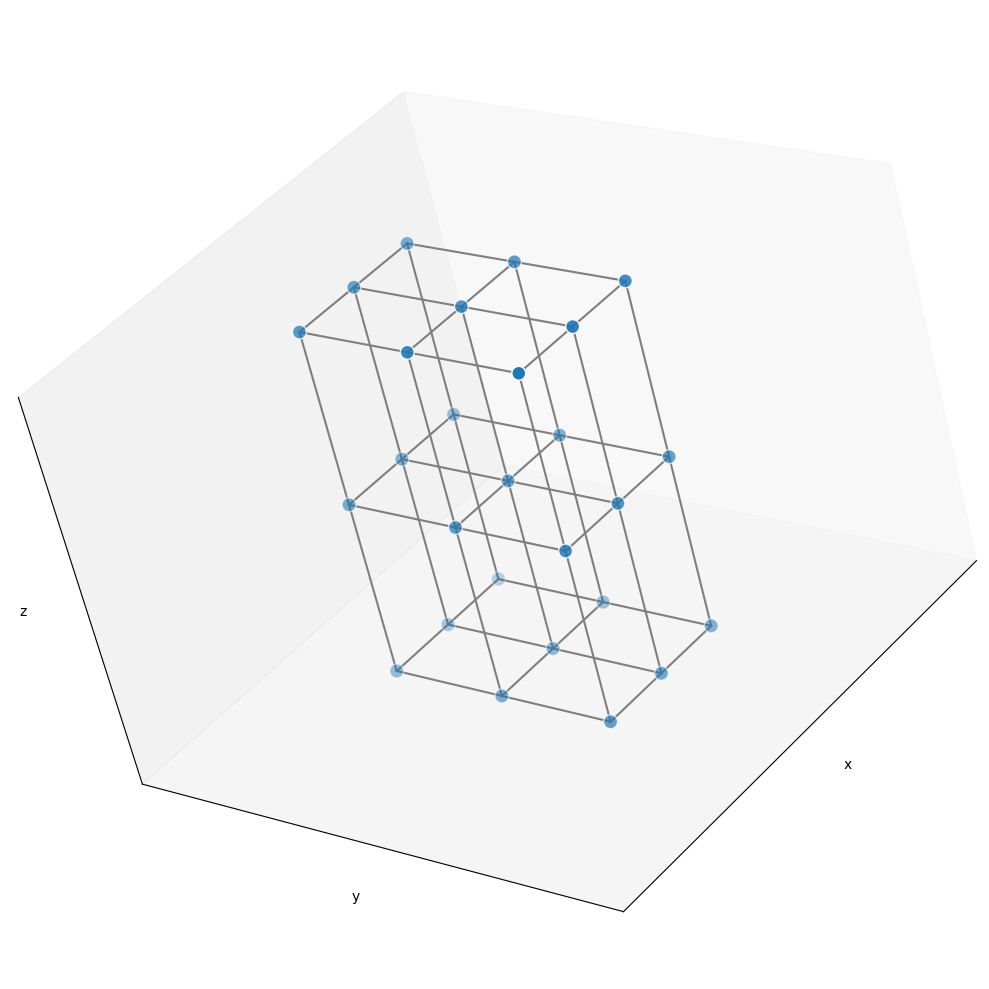

In [251]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# The graph to visualize
G = nx.grid_graph(dim=(range(-1, 2), range(-1, 2), range(-1, 2)))

# 3d spring layout
#pos = nx.spring_layout(G, dim=3, seed=779)
pos = {(x, y, z):(math.log2(2) * x, math.log2(3) * y, math.log2(5) * z) for x,y,z in G.nodes()}
# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=100, ec="w")

ax.view_init(elev=30, azim=45, roll=15)

ax.axis('equal')

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()

In [31]:
from tikzpy import TikzPicture

def collapseLabel(fraction):
    if fraction < 1:
        while fraction < 1:
            fraction *= Fraction(2, 1)
    elif fraction >= 2:
        while fraction >= 2:
            fraction *= Fraction(1, 2)
    return fraction

def getLabel(x, y, z, collapse = False):
    num = 1
    den = 1
    if x >= 0:
        num *= math.pow(3, x)
    else:
        den *= math.pow(3, abs(x))
        
    if y >= 0:
        num *= math.pow(5, y)
    else:
        den *= math.pow(5, abs(y))
        
    if z >= 0:
        num *= math.pow(2, z)
    else:
        den *= math.pow(2, abs(z))
    if collapse:
        fraction = collapseLabel(Fraction(int(num), int(den)))
    else:
        fraction = Fraction(int(num), int(den))
    num = fraction.numerator
    den = fraction.denominator
    return str(int(num)) + "/" + str(int(den))
    
def chord2Points(chord):
    points = []
    for n in chord:
        counter = Counter(n)
        points.append(tuple([counter[d] - counter[-d] for d in [2, 3, 5]]))
    return tuple(points)

def genLattice(chord = None, ranges = None, filename = "tikz", collapse = False,  scale = 1):

    dx = math.log2(3) * scale
    dy = math.log2(5) * scale
    dz = math.log2(2) * scale

    if chord:
        set = chord2Points(chord)

    if ranges:
        rz,rx,ry = ranges
    else:
        rz,rx,ry = [[min(t), max(t) + 1] for t in list(zip(*set))]

    if collapse:
        rz = [0, 1]
    
    tikz = TikzPicture(center=True)
    tikz.set_tdplotsetmaincoords(30, -30)
    tikz.options = "tdplot_main_coords"
    
    for x in range(*rx):
        for y in range(*ry):
            for z in range(*rz):
                line = tikz.line((x * dx - dx / 2, y * dy, z * dz), (x * dx + dx / 2, y * dy, z * dz), options="thick, black, -")
                line = tikz.line((x * dx, y * dy - dy / 2, z * dz), (x * dx, y * dy + dy / 2, z * dz), options="thick, black, -")
                if not collapse:
                    line = tikz.line((x * dx, y * dy, z * dz - dz / 2), (x * dx, y * dy, z * dz + dz / 2), options="thick, black, -")
                node = tikz.node((x * dx, y * dy, z * dz), options="draw, fill=white, scale=0.5", text=getLabel(x,y,z, collapse))

    if chord:
        for e in set:
            z,x,y = e
            if collapse:
                z = 0
            line = tikz.line((x * dx - dx / 2, y * dy, z * dz), (x * dx + dx / 2, y * dy, z * dz), options="thick, black, -")
            line = tikz.line((x * dx, y * dy - dy / 2, z * dz), (x * dx, y * dy + dy / 2, z * dz), options="thick, black, -")
            if not collapse:
                line = tikz.line((x * dx, y * dy, z * dz - dz / 2), (x * dx, y * dy, z * dz + dz / 2), options="thick, black, -")
            node = tikz.node((x * dx, y * dy, z * dz), options="draw, fill=yellow, scale=0.5", text=getLabel(x,y,z, collapse))

    tikz.compile(filename + ".pdf", True)
    
    texFile = open(filename + ".tex", "w+")
    texFile.write(tikz.code())
    texFile.close()

In [72]:
edge = (((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (2, 2, -3), (-2, 3), (-2, -2, 5)), {'melodic_movement': 813.6862861351653, 'transposition': (2, 3, -5)})
chord = transpose_chord(edge[0], (-2, -3, 5))
#genLattice(chord, path="figure.pdf", collapse=False)
genLattice(chord, ranges=[[-2, 2], [-2, 2], [-2, 2]], filename="compact_set_1_transposed_expanded_padded", collapse=False, scale=2)

Rc files read:
  NONE
Latexmk: Run number 1 of rule 'pdflatex'
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Arch Linux) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
Latexmk: Getting log file 'tmp/tex_file.log'



In [79]:
edge = (((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (2, 2, -3), (-2, 3), (-2, -2, 5)), {'melodic_movement': 813.6862861351653, 'transposition': (2, 3, -5)})
chord = transpose_chord(edge[0], (-2, -3, 5))
#genLattice(chord, path="figure.pdf", collapse=False)
genLattice(chord, ranges=[[-2, 2], [-1, 3], [-1, 2]], filename="compact_set_1_transposed_expanded_padded", collapse=False, scale=2)

Rc files read:
  NONE
Latexmk: Run number 1 of rule 'pdflatex'
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Arch Linux) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
Latexmk: Getting log file 'tmp/tex_file.log'



In [80]:
edge = (((), (-2, 3), (2, 3, -5), (3, 3, -5)), ((), (2, 2, -3), (-2, 3), (-2, -2, 5)), {'melodic_movement': 813.6862861351653, 'transposition': (2, 3, -5)})
chord = edge[0]
#genLattice(chord, path="figure.pdf", collapse=False)
genLattice(chord, ranges=[[-2, 2], [-1, 3], [-1, 2]], filename="compact_set_1_expanded_padded", collapse=False, scale=2)

Rc files read:
  NONE
Latexmk: Run number 1 of rule 'pdflatex'
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Arch Linux) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
Latexmk: Getting log file 'tmp/tex_file.log'



In [307]:
def sums(length, total_sum):
    if length == 0:
        yield ()
    else:
        for value in it.chain(range(0, total_sum + 1), range(-1 * total_sum, 0)):
            for permutation in sums(length - 1, total_sum - abs(value)):
                yield (value,) + permutation

L = list(sums(5, 3))
print('total permutations:',len(L))

#63, 25, 7, 1
# First and last 10 of list
for i in L:
    print(i)

total permutations: 231
(-3, 0, 0, 0, 0)
(-2, -1, 0, 0, 0)
(-2, 0, -1, 0, 0)
(-2, 0, 0, -1, 0)
(-2, 0, 0, 0, -1)
(-2, 0, 0, 0, 0)
(-2, 0, 0, 0, 1)
(-2, 0, 0, 1, 0)
(-2, 0, 1, 0, 0)
(-2, 1, 0, 0, 0)
(-1, -2, 0, 0, 0)
(-1, -1, -1, 0, 0)
(-1, -1, 0, -1, 0)
(-1, -1, 0, 0, -1)
(-1, -1, 0, 0, 0)
(-1, -1, 0, 0, 1)
(-1, -1, 0, 1, 0)
(-1, -1, 1, 0, 0)
(-1, 0, -2, 0, 0)
(-1, 0, -1, -1, 0)
(-1, 0, -1, 0, -1)
(-1, 0, -1, 0, 0)
(-1, 0, -1, 0, 1)
(-1, 0, -1, 1, 0)
(-1, 0, 0, -2, 0)
(-1, 0, 0, -1, -1)
(-1, 0, 0, -1, 0)
(-1, 0, 0, -1, 1)
(-1, 0, 0, 0, -2)
(-1, 0, 0, 0, -1)
(-1, 0, 0, 0, 0)
(-1, 0, 0, 0, 1)
(-1, 0, 0, 0, 2)
(-1, 0, 0, 1, -1)
(-1, 0, 0, 1, 0)
(-1, 0, 0, 1, 1)
(-1, 0, 0, 2, 0)
(-1, 0, 1, -1, 0)
(-1, 0, 1, 0, -1)
(-1, 0, 1, 0, 0)
(-1, 0, 1, 0, 1)
(-1, 0, 1, 1, 0)
(-1, 0, 2, 0, 0)
(-1, 1, -1, 0, 0)
(-1, 1, 0, -1, 0)
(-1, 1, 0, 0, -1)
(-1, 1, 0, 0, 0)
(-1, 1, 0, 0, 1)
(-1, 1, 0, 1, 0)
(-1, 1, 1, 0, 0)
(-1, 2, 0, 0, 0)
(0, -3, 0, 0, 0)
(0, -2, -1, 0, 0)
(0, -2, 0, -1, 0)
(0, -2, 0, 0, -1)
(0

In [291]:
(-3, 0, 0, 0, 0) + (-3, 0, 0, 0, 0)

(-3, 0, 0, 0, 0, -3, 0, 0, 0, 0)